# Inter-annotator agreement scores

* Krippendorff alpha
* Fleiss Kappa
* Ratio of partial agreement (intersection)
* Ratio of Jaccard agreement (intersection over union)
* Ratio of exact agreement

In [296]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from collections import defaultdict
import os
import pymysql
import scipy
from tqdm import tqdm
import ast
import utils
import importlib

In [461]:
scores = defaultdict(list)
# values [krippendorf_alpha, fleiss_kappa, partial, jaccard, exact]

# krippendorff_alpha

In [462]:
import krippendorff_alpha as kpa
'''
data is in the format
    [
        {unit1:value, unit2:value, ...},  # coder 1
        {unit1:value, unit3:value, ...},   # coder 2
        ...                            # more coders
    ]
where unit is the sentence id
and value is the label (in our case a string representation of a list of labels)
'''

'\ndata is in the format\n    [\n        {unit1:value, unit2:value, ...},  # coder 1\n        {unit1:value, unit3:value, ...},   # coder 2\n        ...                            # more coders\n    ]\nwhere unit is the sentence id\nand value is the label (in our case a string representation of a list of labels)\n'

In [577]:
features = ['Aspect',
 'Emphasis',
 'Figures_of_argument',
 'Figures_of_word_choice',
 'Language_of_origin',
 'Language_varieties',
 'Lexical_and_semantic_fields',
 'Modifying_clauses',
 'Modifying_phrases',
 'Mood',
 'New_words_and_changing_uses',
 'Parallelism',
 'Phrases_built_on_nouns',
 'Phrases_built_on_verbs',
 'Predication',
 'Prosody_and_punctuation',
 'Sentence_architecture',
 'Series',
 'Subject_choices',
 'Tense',
 'Tropes',
 'Verb_choices']

In [464]:
importlib.reload(kpa)

for feature in features:
    df = pd.read_csv("data/clean-annotated-data/non_agreed_sentences_"+feature+".csv")
    df = df[["sentence_id","props_a20","props_a21","props_a22"]]

    a20_input = df[["sentence_id","props_a20"]].set_index('sentence_id').to_dict()['props_a20']
    a21_input = df[["sentence_id","props_a21"]].set_index('sentence_id').to_dict()['props_a21']
    a22_input = df[["sentence_id","props_a22"]].set_index('sentence_id').to_dict()['props_a22']

    input_array = [a20_input,a21_input,a22_input]

    missing = '[]' # indicator for missing values
    
    
    alpha = kpa.krippendorff_alpha(input_array, kpa.nominal_metric, convert_items=str, missing_items=missing)
    alpha = float("{:.3f}".format(alpha))
    # print("="*100)
    # print(feature.replace("_"," "))
    # print("~"*100)
    # print("nominal krippendorff_alpha: %.3f" % alpha)

    scores[feature].append(alpha)

# Fleiss Kappa

In [465]:
import fleiss_kappa as flk


# example
rate = \
    [
        [0,0,0,0,14],
        [0,2,6,4,2],
        [0,0,3,5,6],
        [0,3,9,2,0],
        [2,2,8,1,1],
        [7,7,0,0,0],
        [3,2,6,3,0],
        [2,5,3,2,2],
        [6,5,2,1,0],
        [0,2,2,3,7]
    ]
kappa = flk.fleissKappa(rate,14)
assert(kappa==0.21)

In [466]:
from collections import Counter
importlib.reload(flk)

def convert(x):
    as_list = [x['props_a20'],x['props_a21'],x['props_a22']]
    c = Counter(as_list)
    return c

for feature in features:

    df = pd.read_csv("data/clean-annotated-data/non_agreed_sentences_"+feature+".csv")
    df = df[["sentence_id","props_a20","props_a21","props_a22"]]

    categories = list(set(df["props_a20"]).union(set(df["props_a21"]),set(df["props_a22"])))

    df['all_properties'] = df.apply(lambda x: convert(x), axis=1)
    
    # initialize a matrix of 0s
    matrix = [[0 for i in range(len(categories))] for j in range(len(df)) ]

    
    for i, item in enumerate(df['all_properties']):

        for key,val in item.items():
            j = categories.index(key)
            matrix[i][j] = val

    kappa = flk.fleissKappa(matrix,3)
    # print("="*100)
    # print(feature)
    # print("~"*100)
    
    
    scores[feature].append(kappa)

# Exact, Overlap, Jaccard

In [467]:
def reset(x):
    if (x["exact"] == 1 and x["props_a20"] == []):
        return None # ignore rows where there are no annotations
    else:
        return x["exact"]

    
def convert(x):
        a20 = set(x['props_a20'])
        a21 = set(x['props_a21'])
        a22 = set(x['props_a22'])

        intersect = a20.intersection(a21,a22)
        union = a20.union(a21,a22)

        if len(union) == 0:
            jaccard = None # ignore rows where there are no annotations
        else:
            jaccard = len(intersect)/len(union)

        return jaccard
    
    
for feature in features:
    df = pd.read_csv("data/clean-annotated-data/non_agreed_sentences_"+feature+".csv")
    df = df[["sentence_id","props_a20","props_a21","props_a22"]]

    df["props_a20"] = df["props_a20"].apply(lambda x: ast.literal_eval(x))
    df["props_a21"] = df["props_a21"].apply(lambda x: ast.literal_eval(x))
    df["props_a22"] = df["props_a22"].apply(lambda x: ast.literal_eval(x))

    df['exact'] = df.apply(lambda x : int(x["props_a20"] == x["props_a21"] == x["props_a22"]), axis=1)
    df['exact'] = df.apply(lambda x : reset(x), axis=1) # ignore rows where there are no annotations

    df['partial'] = df.apply(lambda x : int(len(set(x["props_a20"]).intersection(set(x["props_a21"]), set(x["props_a22"]))) > 0), axis=1)
    df['jaccard'] = df.apply(lambda x: convert(x), axis=1)
    
    df = df.dropna()
    exact = sum(df['exact'])/len(df)
    partial = sum(df['partial'])/len(df)
    jaccard = sum(df['jaccard'])/len(df)
    
    
    exact = float("{:.3f}".format(exact))
    jaccard = float("{:.3f}".format(jaccard))
    partial = float("{:.3f}".format(partial))

#     print("="*100)
#     print(feature)
#     print("~"*100)
#     print("Exact: ", exact)
#     print("Overlap: ", partial)
    
#     print("Jaccard agreement: ",jaccard)
    
    
    scores[feature].append(partial)
    scores[feature].append(jaccard)
    scores[feature].append(exact)

In [610]:
agreement_scores = pd.DataFrame.from_dict(scores, columns=[["krippendorf_alpha", "fleiss_kappa", "partial", "jaccard", "exact"]],orient='index')

In [611]:
agreement_scores = agreement_scores.reset_index()
agreement_scores = agreement_scores.rename(columns={"index":"feature"})

In [612]:
agreement_scores

,feature,krippendorf_alpha,fleiss_kappa,partial,jaccard,exact
0,Aspect,0.364,0.363,0.840,0.573,0.320
1,Emphasis,-0.023,-0.024,0.336,0.325,0.314
2,Figures_of_argument,0.330,0.329,0.109,0.101,0.094
3,Figures_of_word_choice,0.171,0.170,0.086,0.067,0.047
4,Language_of_origin,-0.101,-0.102,0.524,0.282,0.042
5,Language_varieties,0.074,0.073,0.975,0.613,0.126
6,Lexical_and_semantic_fields,0.057,0.056,0.739,0.269,0.036
7,Modifying_clauses,0.496,0.495,0.474,0.355,0.255
8,Modifying_phrases,0.294,0.293,0.697,0.543,0.370
9,Mood,0.458,0.458,0.894,0.870,0.846


In [613]:
#GPT4, GPT3.5, GPT3.5-t0.2
s = np.array([['Aspect',0.9795918367346939,0.567567567567568,0.827027027027027],
 ['Emphasis',0.5880398671096345,0.389355742296919,0.871148459383754],
 ['Figures_of_argument',0.9253731343283582,0.428571428571429,0.829131652661064],
 ['Figures_of_word_choice',0.8732394366197183,0.341736694677871,0.694677871148459],
 ['Language_of_origin',0.42138364779874216,0.352941176470588,0.661064425770308],
 ['Language_varieties',0.05863192182410423,0.156862745098039,0.507002801120448],
 ['Lexical_and_semantic_fields',0.3639705882352941,0.128851540616246,0.53781512605042],
 ['Modifying_clauses',0.7588235294117647,0.322128851540616,0.73109243697479],
 ['Modifying_phrases',0.16037735849056603,0.375350140056022,0.739495798319328],
 ['Mood',0.9354838709677419,0.733893557422969,0.873949579831933],
 ['New_words_and_changing_uses',0.8660714285714286,0.240896358543417,0.61624649859944],
 ['Parallelism',0.9574468085106383,0.38375350140056,0.7703081232493],
 ['Phrases_built_on_nouns',0.9534883720930233,0.476190476190476,0.862745098039216],
 ['Phrases_built_on_verbs',0.9759036144578314,0.431372549019608,0.92436974789916],
 ['Predication',0.768595041322314,0.459383753501401,0.745098039215686],
 ['Prosody_and_punctuation',0,0.067226890756303,0.38375350140056],
 ['Sentence_architecture',0.575,0.411764705882353,0.873949579831933],
 ['Series',1.0,0.411764705882353,0.747899159663866],
 ['Subject_choices',0.6521739130434783,0.330532212885154,0.6687306501547987],
 ['Tense',0.8996282527881041,0.352941176470588,0.747081712062257],
 ['Tropes',0.8532110091743119,0.254901960784314,0.649859943977591],
 ['Verb_choices',0.678082191780822,0.476190476190476,0.750700280112045]])


In [614]:
agreement_scores['GPT4-exact'] = s[:,1:2]
agreement_scores['GPT3.5-exact'] = s[:,2:3]
agreement_scores['GPT3.5-0.2'] = s[:,3:]

In [615]:
agreement_scores['GPT4-exact'] = agreement_scores['GPT4-exact'].apply(lambda x: float(x), axis=1)
agreement_scores['GPT3.5-exact'] = agreement_scores['GPT3.5-exact'].apply(lambda x: float(x), axis=1)
agreement_scores['GPT3.5-0.2'] = agreement_scores['GPT3.5-0.2'].apply(lambda x: float(x), axis=1)

In [616]:
agreement_scores = agreement_scores[["feature","krippendorf_alpha","fleiss_kappa","jaccard","exact","GPT4-exact","GPT3.5-exact","GPT3.5-0.2"]]

In [617]:
agreement_scores.to_csv("inter-annotator-agreement-scores.csv",index=None)
agreement_scores = pd.read_csv("inter-annotator-agreement-scores.csv")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


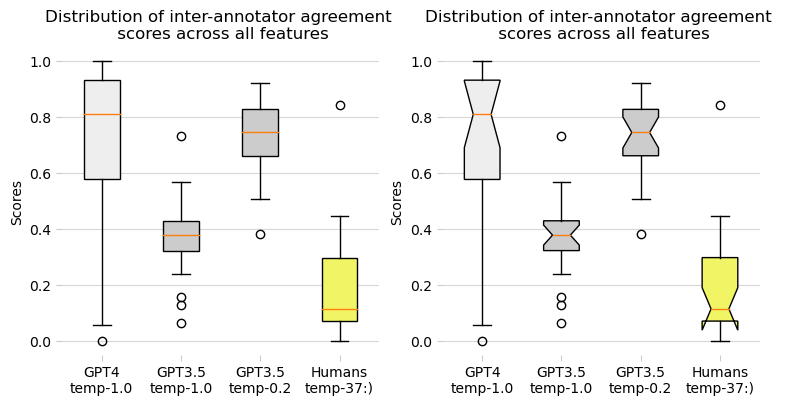

In [619]:
import matplotlib.pyplot as plt
import numpy as np


all_data = [list(agreement_scores['GPT4-exact']),
            list(agreement_scores['GPT3.5-exact']),
            list(agreement_scores['GPT3.5-0.2']),
            list(agreement_scores['exact'])]

labels = ['GPT4\ntemp-1.0', 'GPT3.5\ntemp-1.0', 'GPT3.5\ntemp-0.2','Humans\ntemp-37:)']

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

# rectangular box plot
bplot1 = ax1.boxplot(all_data,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks
ax1.set_title('Distribution of inter-annotator agreement \n scores across all features')

# notch shape box plot
bplot2 = ax2.boxplot(all_data,
                     notch=True,  # notch shape
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks
ax2.set_title('Distribution of inter-annotator agreement \n scores across all features')

# fill with colors
colors = ['#eeeeee', '#cccccc', '#cccccc', '#F0F465']
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

# adding horizontal grid lines
for ax in [ax1, ax2]:
    ax.yaxis.grid(True)
    # ax.set_xlabel('Groups')
    ax.set_ylabel('Scores')

    
    ax.set(frame_on=False)
    ax.tick_params(length=4,grid_alpha=0.5, color="#cccccc")
    
plt.savefig("GPT-vs-humans.eps",format='eps',bbox_inches='tight', pad_inches=0)
plt.show()

In [554]:
agreement_scores['GPT4-exact'] = agreement_scores['GPT4-exact'].apply(lambda x: float("{:.3f}".format(x)))
agreement_scores['GPT3.5-exact'] = agreement_scores['GPT3.5-exact'].apply(lambda x: float("{:.3f}".format(x)))

In [575]:
agreement_scores = agreement_scores.sort_values(by='feature',ascending=True)
agreement_scores

,feature,krippendorf_alpha,fleiss_kappa,jaccard,exact,GPT4-exact,GPT3.5-exact
0,Aspect,0.364,0.363,0.573,0.320,0.980,0.568
1,Emphasis,-0.023,-0.024,0.325,0.314,0.588,0.389
2,Figures_of_argument,0.330,0.329,0.101,0.094,0.925,0.429
3,Figures_of_word_choice,0.171,0.170,0.067,0.047,0.873,0.342
4,Language_of_origin,-0.101,-0.102,0.282,0.042,0.421,0.353
5,Language_varieties,0.074,0.073,0.613,0.126,0.059,0.157
6,Lexical_and_semantic_fields,0.057,0.056,0.269,0.036,0.364,0.129
7,Modifying_clauses,0.496,0.495,0.355,0.255,0.759,0.322
8,Modifying_phrases,0.294,0.293,0.543,0.370,0.160,0.375
9,Mood,0.458,0.458,0.870,0.846,0.935,0.734


In [576]:
agreement_scores.to_latex("agreement_scores.tex")

/var/folders/vt/g1t9ds3s01z05zs4qg2dngk80000gn/T/ipykernel_35588/4100780166.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  agreement_scores.to_latex("agreement_scores.tex")


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


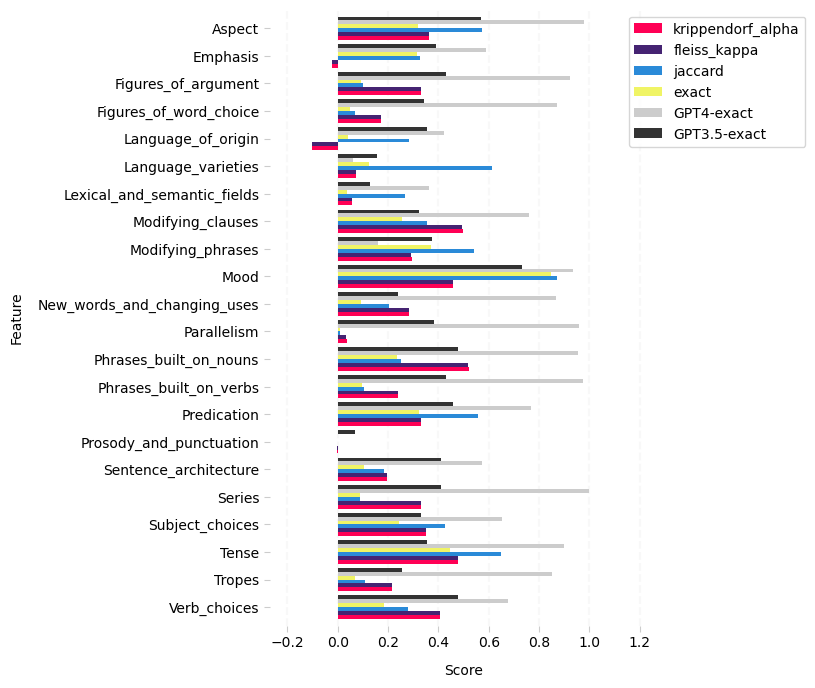

In [578]:
agreement_scores = agreement_scores.sort_values(by='feature',ascending=False)
colors = ["#ff0055","#452372","#2A8AD8","#F0F465","#CCCCCC","#333333","#50C5B7","#9CEC5B"]
ax = agreement_scores.plot(kind='barh', figsize=(5, 8), color=colors, zorder=2, width=0.85)

# Despine
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)

# # Switch off ticks
# ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

ax.set(frame_on=False)

ax.tick_params(length=4,grid_alpha=0.5, color="#cccccc")

# Draw vertical axis lines
vals = ax.get_xticks()

ax.set_yticklabels(features[::-1])

for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

# Set x-axis label
ax.set_xlabel("Score", labelpad=10, weight='normal', size=10)

# Set y-axis label
ax.set_ylabel("Feature", labelpad=10, weight='normal', size=10)
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.0))
plt.savefig("agreement-scores-wGPT.eps",format='eps',bbox_inches='tight', pad_inches=0)
# ax.set_axis_off()
# Format y-axis label
# ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

1. Shapiro-Wilk test of normality
    (The null hypothesis of Shapiro’s test is that the population is distributed normally.)
2. Levene’s test for homogeneity of variances
3. Independent T-test

The Mann-Whitney U Test is particularly useful when you are assessing the difference between two independent groups with low numbers of individuals in each group (usually less than 30), which are not normally distributed, and where the data are continuous. The null hypothesis is that the distribution underlying sample x is the same as the distribution underlying sample y.

In [431]:
agreement_scores

,feature,krippendorf_alpha,fleiss_kappa,jaccard,exact,GPT-exact
0,Aspect,0.364,0.363,0.573,0.320,0.979592
1,Emphasis,-0.023,-0.024,0.325,0.314,0.588040
2,Figures_of_argument,0.330,0.329,0.101,0.094,0.925373
3,Figures_of_word_choice,0.171,0.170,0.067,0.047,0.873239
4,Language_of_origin,-0.101,-0.102,0.282,0.042,0.421384
5,Language_varieties,0.074,0.073,0.613,0.126,0.058632
6,Lexical_and_semantic_fields,0.057,0.056,0.269,0.036,0.363971
7,Modifying_clauses,0.496,0.495,0.355,0.255,0.758824
8,Modifying_phrases,0.294,0.293,0.543,0.370,0.160377
9,Mood,0.458,0.458,0.870,0.846,0.935484


In [435]:
import scipy

In [437]:
scipy.stats.shapiro(list(agreement_scores['GPT-exact']))
# we can reject the null hypothesis since the p-value is < 0.05. i.e. the data does NOT come from a normal distribution.

ShapiroResult(statistic=0.8543975353240967, pvalue=0.005062012001872063)

In [435]:
scipy.stats.shapiro(list(agreement_scores['exact']))

ShapiroResult(statistic=0.8116735219955444, pvalue=0.000994961243122816)

In [438]:
x = list(agreement_scores['GPT-exact'])
y = list(agreement_scores['exact'])
scipy.stats.mannwhitneyu(x, y, method='auto')

# https://ocw.umb.edu/psychology/psych-270/other-materials/RelativeResourceManager.pdf
# the critical value = 127 for a two sided test where N1 and N2 both = 20
# Since 430 > 127, we can do not reject the null hypothesis that the two distributions are the same

MannwhitneyuResult(statistic=403.0, pvalue=4.682545280796186e-06)